## Install Libraries

In [1]:
!pip install split-folders

In [2]:
!pip install torchsummary

## Import Libraries

In [3]:
import os                                         # To work with OS commands
import warnings                                   # To avoid python warnings
import pathlib                                    # To work with path commands                                    
import numpy as np                                # To work with Numpy arrays
import matplotlib.pyplot as plt                   # To Visualization
import seaborn as sns                             # To Visualization
import splitfolders                               # To split data to train, test and validation folders
from termcolor import colored                     # To Colorfull output
from datetime import datetime                     # To calculate durations

import torch                                      # To work with TORCH framework
import torch.nn as nn                             # To work with Neural Networks
import torchvision                                # To work with image datasets
import torchvision.transforms as transforms       # To create data transforms

from sklearn.metrics import confusion_matrix, classification_report # To Evaluate the result

from torchsummary import summary

In [4]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Enviroment

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load Data

In [6]:
data_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [7]:
# create folder for train, validation and test set
splitfolders.ratio(
    input=data_path, output='imgs', seed=42, ratio=(0.7, 0.15, 0.15)
)

Copying files: 75000 files [08:52, 140.98 files/s]


In [8]:
base_dir = '/kaggle/working/imgs'
base_dir = pathlib.Path(base_dir)

## DataLoader

In [9]:
transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])

In [10]:
import torch.utils.data

batch_size = 32

# Train data
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir, 'train'), transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True
)
print(colored(f'Train Folder :\n ', 'green', attrs=['bold']))
print(train_ds)

# Validation Data
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir, 'val'), transform=transform
)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True
)
print(colored(f'Validation Folder :\n ', 'green', attrs=['bold']))
print(val_ds)

# Test Data
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir, 'test'), transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True
)
print(colored(f'Test Folder :\n ', 'green', attrs=['bold']))
print(test_ds)

Train Folder :
 
Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/imgs/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=0, std=1)
           )
Validation Folder :
 
Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/imgs/val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=0, std=1)
           )
Test Folder :
 
Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/imgs/test
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=0, std=1)
           )


## Data Shape

In [11]:
for key, value in {'Train': train_loader, 'validation': val_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(colored(f'{key}', 'green', attrs=['bold']))
        print(f"Shape of images [Batch_size, Channels, Height, Width]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print('-'*45)
        break

Train
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

---------------------------------------------
validation
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

---------------------------------------------
Test
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

---------------------------------------------


In [12]:
labels_map = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag",
}

## Plot Images

In [13]:
imgs, labels = next(iter(train_loader))

print('Labels : ', labels)
print('-'*45)
num_classes = torch.unique(labels).numel()
print(f'Number of classes : {num_classes}')

Labels :  tensor([4, 0, 3, 3, 0, 0, 3, 2, 0, 3, 4, 2, 4, 1, 2, 4, 1, 4, 4, 0, 0, 0, 2, 4,
        3, 3, 1, 2, 4, 0, 1, 2])
---------------------------------------------
Number of classes : 5


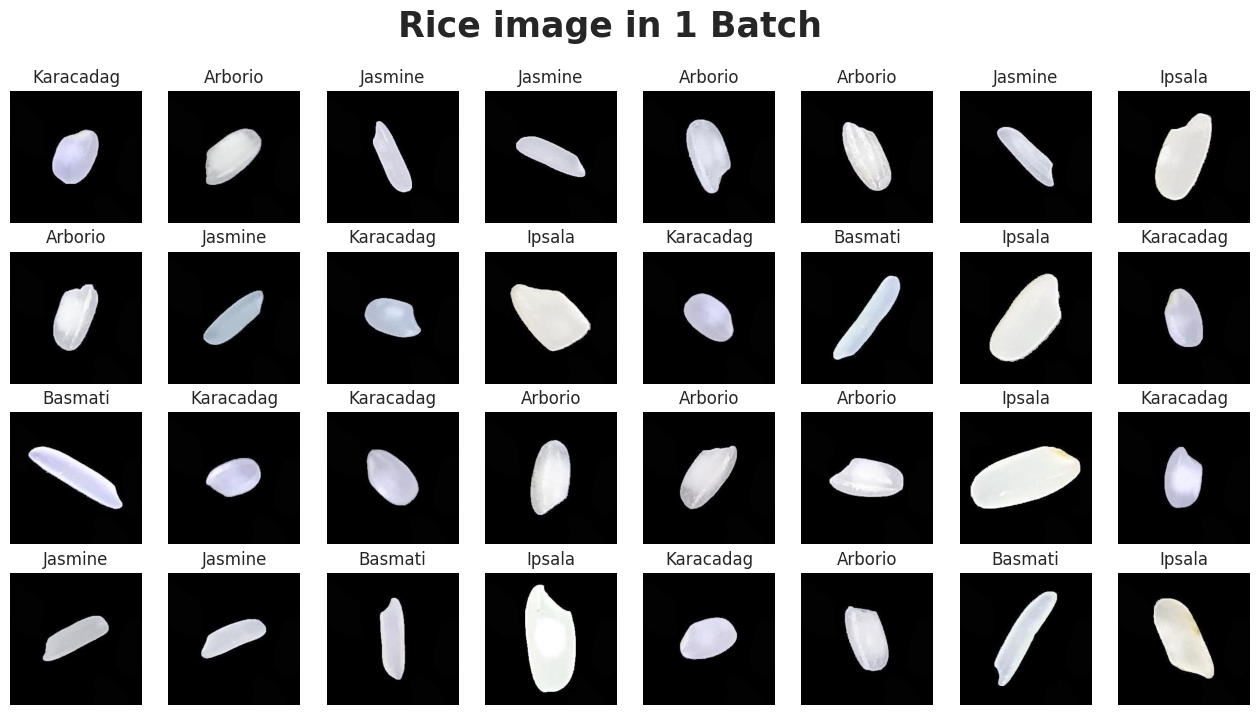

In [14]:
plt.subplots(4, 8, figsize=(16,8))
plt.suptitle("Rice image in 1 Batch", fontsize=25, fontweight='bold')
for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    img = imgs[i].permute(1,2,0)
    plt.imshow(img)
    label = labels_map[int(labels[i])]
    plt.title(label)
    plt.axis('off')

plt.show()

## Create Model

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #### CONVs
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(128)
        
        ### Dense
        self.fc1 = nn.Linear(128*29*29, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        #### CONVs
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.bn1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.bn2(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.pool3(out)
        out = self.bn3(out)
        
        #### Flatten
        out = out.view(out.size(0), -1)
        
        #### Dense
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        out = self.relu5(out)
        out = self.fc3(out)
        
        return out

In [16]:
model = CNN(num_classes=num_classes)
model.to(device)
summary(model, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 248, 248]             896
              ReLU-2         [-1, 32, 248, 248]               0
         MaxPool2d-3         [-1, 32, 124, 124]               0
       BatchNorm2d-4         [-1, 32, 124, 124]              64
            Conv2d-5         [-1, 64, 122, 122]          18,496
              ReLU-6         [-1, 64, 122, 122]               0
         MaxPool2d-7           [-1, 64, 61, 61]               0
       BatchNorm2d-8           [-1, 64, 61, 61]             128
            Conv2d-9          [-1, 128, 59, 59]          73,856
             ReLU-10          [-1, 128, 59, 59]               0
        MaxPool2d-11          [-1, 128, 29, 29]               0
      BatchNorm2d-12          [-1, 128, 29, 29]             256
           Linear-13                  [-1, 128]      13,779,072
             ReLU-14                  [

## Train Model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Training
    model.train()
    t0 = datetime.now()
    train_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        y_pred = model(images)
        loss = criterion(y_pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
        
    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss
    train_accs[epoch] = n_correct / n_total
    
    # Validation
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            val_loss.append(loss.item())

            # Train Accuracy
            _, prediction = torch.max(y_pred, 1)
            n_correct += (prediction==labels).sum().item()
            n_total += labels.shape[0]
        
    val_loss = np.mean(val_loss)
    val_losses[epoch] = val_loss
    val_accs[epoch] = n_correct / n_total
    
    dt = datetime.now() - t0
    
    print(f'Epoch [{epoch+1}/{num_epochs}] -> Train Loss:{train_loss:.4f}, Train Acc:{train_accs[epoch]:.4f}| Val Loss:{val_loss:.4f}, Val Acc:{val_accs[epoch]:.4f}| Duration : {dt}')

Epoch [1/5] -> Train Loss:0.0845, Train Acc:0.9740| Val Loss:0.0673, Val Acc:0.9791| Duration : 0:02:41.066440
Epoch [2/5] -> Train Loss:0.0342, Train Acc:0.9889| Val Loss:0.0187, Val Acc:0.9944| Duration : 0:02:39.578081
Epoch [3/5] -> Train Loss:0.0407, Train Acc:0.9874| Val Loss:0.0396, Val Acc:0.9865| Duration : 0:02:40.185162
Epoch [4/5] -> Train Loss:0.0286, Train Acc:0.9911| Val Loss:0.0195, Val Acc:0.9943| Duration : 0:02:39.710852
Epoch [5/5] -> Train Loss:0.0265, Train Acc:0.9924| Val Loss:0.0221, Val Acc:0.9934| Duration : 0:02:39.905354


In [18]:
torch.save(model.state_dict(), "rice_cnn_00.pth")

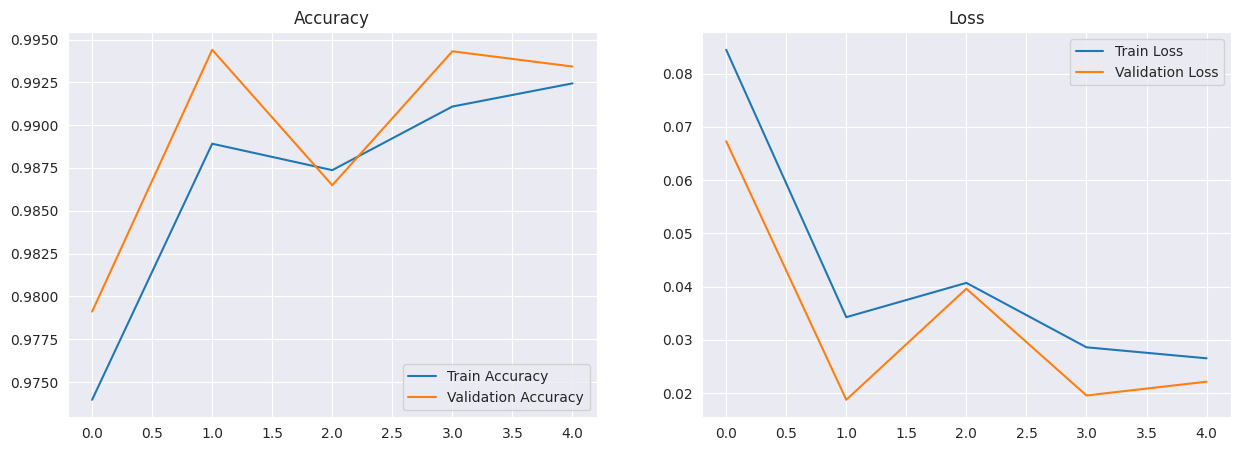

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_accs, label="Train Accuracy")
ax[0].plot(val_accs, label="Validation Accuracy")
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(train_losses, label="Train Loss")
ax[1].plot(val_losses, label="Validation Loss")
ax[1].set_title('Loss')
ax[1].legend()

## Evaluation

In [20]:
with torch.no_grad():
    model.eval()
    t0 = datetime.now()
    test_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        
        test_loss.append(loss.item())
        
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
        
    test_loss = np.mean(test_loss)
    test_acc = n_correct / n_total
    dt = datetime.now() - t0
    print(colored(f'Loss:{test_loss:.4f}\nAccuracy:{test_acc:.4f}\nDuration:{dt}', 'green', attrs=['bold']))

Loss:0.0206
Accuracy:0.9932
Duration:0:00:20.508075


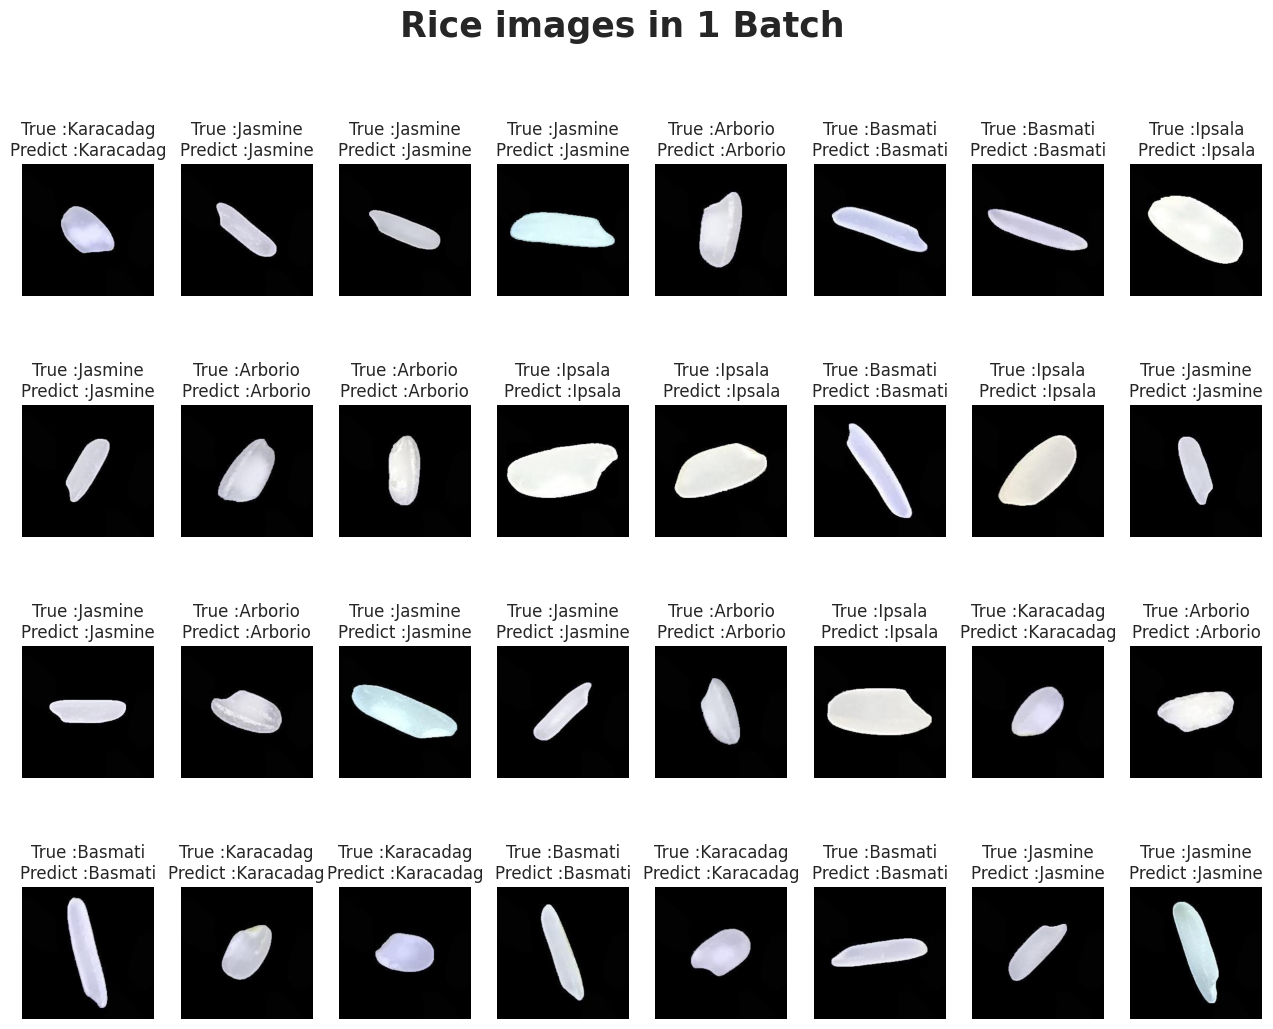

In [21]:
cpu_model = model.cpu()

imgs, labels = next(iter(test_loader))

plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Rice images in 1 Batch', fontsize=25, fontweight='bold')
for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    img = imgs[i].permute(1, 2, 0)
    plt.imshow(img)
    label = labels_map[int(labels[i])]
    img = imgs[i].unsqueeze(0)
    out = cpu_model(img)
    predict = labels_map[int(out.argmax())]
    plt.title(f'True :{label}\nPredict :{predict}')
    plt.axis('off')
    
plt.show()

In [22]:
model = model.to(device)

y_true = []
y_pred = []

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.numpy()
    
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2250
         1.0       0.99      0.99      0.99      2250
         2.0       1.00      1.00      1.00      2250
         3.0       0.99      0.99      0.99      2250
         4.0       0.99      1.00      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



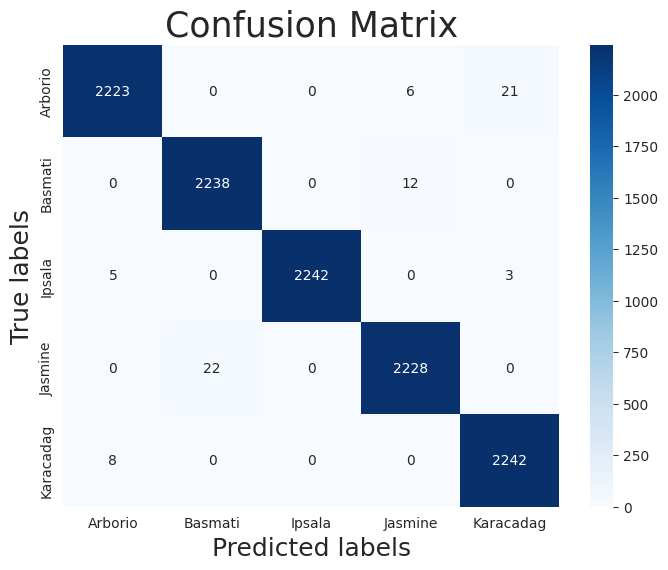

In [23]:
classes = labels_map.values()

print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_true, y_pred):
    '''Plotting Confusion Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
    ax.set_xlabel('Predicted labels', fontsize=18)
    ax.set_ylabel('True labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.show()
    
plot_confusion_matrix(y_true, y_pred)